# Logistic fits for country COVID metrics.

* `zone_df` is pandas DataFrame containing information on each zone.
* `ts_df` is a pandas DataFrame containing time-series COVID metrics



In [60]:
## Initialisation
import pandas as pd
import geopandas
import statsmodels.api as sm
from statsmodels.formula.api import ols
import pycountry
import pycountry_convert
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import plotly.express as px
from covid.grabbers import grab_wbdata, grab_JHU
from covid.utils import print_wb_indicators, print_wb_sources, get_x_day, rchop, drop_y, get_latest_valid
from covid.constants import WB_DF_RENAMED_COUNTRIES
from covid.statistics import LogisticModel

# We use two dataframes. One for for storing zone-wide wide and one for timeseries stuff
zone_df = pd.DataFrame(columns=['zone'])
ts_df = pd.DataFrame(columns=['zone', 'date'])


In [61]:
import wbdata

In [62]:
import wbdata

sources = []
wb_sources = wbdata.get_source(display=False)
for source in wb_sources:
    sources.append(int(source['id']))

stop_after_indicators = 1
stop_after_sources = 1
indicators = []
for i, source in enumerate(sources):
    print(f'Processing source {source} ({i} of {len(sources)})')
    wb_indicators = wbdata.get_indicator(source=source, display=False)
    for j, indicator in enumerate(wb_indicators):
        indicators.append(indicator['id'])
        if j >= stop_after_indicators:
            break
    
    if i >= stop_after_sources:
        break


Processing source 1 (0 of 59)
Processing source 2 (1 of 59)


In [63]:
## Timeseries
# Grab JHU time series data
ts_df = grab_JHU()


In [64]:
### Add stats to zone_df
def process_wb_indicator(indicator, column_name=None):
    if column_name is None:
        column_name = indicator
    
    df = grab_wbdata({indicator: column_name})
    df = get_latest_valid(df).reset_index(level=1, drop=True)

    df.index.name='zone'
    df.rename(index=WB_DF_RENAMED_COUNTRIES, inplace=True)

    return df

# Subnational population. Source=50
zone_df = pd.merge(zone_df, process_wb_indicator('SP.POP.TOTL', 'population'), on='zone', how='outer', suffixes=('', '_y'))

# Degree of urbanisation
zone_df = pd.merge(zone_df, process_wb_indicator('SP.URB.TOTL.IN.ZS', 'urbanisation'), on='zone', how='outer', suffixes=('', '_y'))

# Hospital beds per 1K population
zone_df = pd.merge(zone_df, process_wb_indicator('SH.MED.BEDS.ZS', 'hospital_beds_per_1K'), on='zone', how='outer', suffixes=('', '_y'))

# 
# grab indicators and load into data frame
wb_df = grab_wbdata({'VA.EST': 'voice_and_accountability',
                     'GE.EST': 'government_effectiveness', })

gov_df = wb_df.groupby(level='country').tail(5).groupby(level='country').mean()
gov_df.index.name = 'zone'
gov_df.rename(index=WB_DF_RENAMED_COUNTRIES, inplace=True)

# Merge into zone_df
zone_df = pd.merge(zone_df, gov_df, on='zone', how='right', suffixes=('', '_y'))
drop_y(zone_df)

In [65]:
zone_df

,zone,population,urbanisation,hospital_beds_per_1K,voice_and_accountability,government_effectiveness
0,Afghanistan,37172386.0,25.495,0.5,-1.718050,-1.838644
1,Albania,2866376.0,60.319,2.9,-0.251730,-0.629331
2,Algeria,42228429.0,72.629,1.9,-1.128412,-0.818300
3,American Samoa,55465.0,87.153,NaN,NaN,NaN
4,Andorra,77006.0,88.062,2.5,1.497404,1.431379
...,...,...,...,...,...,...
209,Martinique,NaN,NaN,NaN,0.719746,0.909367
210,Netherlands Antilles,NaN,NaN,NaN,NaN,NaN
211,Niue,NaN,NaN,NaN,NaN,NaN
212,Reunion,NaN,NaN,NaN,NaN,NaN


In [66]:
# Add continents to zone_df
def country_to_continent(country, verbose=False):
    if verbose:
        print(f'Processing country: {country}')
    try:
        country_obj = pycountry.countries.search_fuzzy(country)[0]
    except (LookupError, AttributeError) as e:
        print(f'Failed to process {country} due to error: {e}')
        return 'Unknown'
    
    try:
        continent_code = pycountry_convert.country_alpha2_to_continent_code(country_obj.alpha_2)
    except KeyError as e:
        print(f'Failed to process {country} due to error: {e}')
        return 'Unknown'
    
    continent = pycountry_convert.convert_continent_code_to_continent_name(continent_code)
    
    return continent

zone_df['continent'] = zone_df['zone'].apply(country_to_continent)

Failed to process Congo (Kinshasa) due to error: congo (kinshasa)
Failed to process Congo (Brazzaville) due to error: congo (brazzaville)
Failed to process Hong Kong SAR, China due to error: hong kong sar, china
Failed to process Korea, Dem. People���s Rep. due to error: korea, dem. people���s rep.
Failed to process Korea, South due to error: korea, south
Failed to process Laos due to error: laos
Failed to process Macao SAR, China due to error: macao sar, china
Failed to process Micronesia, Fed. Sts. due to error: micronesia, fed. sts.
Failed to process Burma due to error: burma
Failed to process Timor-Leste due to error: "Invalid Country Alpha-2 code: 'TL'"
Failed to process Virgin Islands (U.S.) due to error: virgin islands (u.s.)
Failed to process West Bank and Gaza due to error: west bank and gaza
Failed to process Jersey, Channel Islands due to error: jersey, channel islands
Failed to process Netherlands Antilles due to error: netherlands antilles
Failed to process Taiwan* due to 

In [67]:
# Add population to ts_df
ts_df = pd.merge(ts_df.reset_index(), zone_df.set_index('zone')['population'], left_on='country', right_on='zone', how='left')
ts_df.set_index(['country', 'date'], inplace=True)
ts_df.sort_index(inplace=True)

# Calculate per population
for label in ('cases', 'deaths', 'recoveries'):
    ts_df[label + '_per_1M'] = (ts_df[label] * 10**6) / ts_df['population']

# Calculate outcome
ts_df['deaths_per_recovery'] = ts_df['deaths'] / ts_df['recoveries']


In [68]:
MIN_REGRESSION_DATAPOINTS = 5

label = 'deaths_per_1M'
regression_predict_length = 10
regression_confidence_levels = 0  # 0 to disable
fit_method = 'leastsq'
log_scale = True
annotate_country = True
show_legend = False
countries = 'all'
# countries = ['United Kingdom', 'Italy', 'Spain', 'Denmark', 'Iran', 'Greece', 'US', 'Sweden', 'Austria', 'Germany', 'Norway', 'Japan', 'Australia', 'France', 'China']
# countries = ['Denmark', 'US', 'Iran', 'United Kingdom', 'Sweden', 'Italy', 'Spain']


if countries == 'all':
    countries = ts_df.reset_index()['country'].unique()


if label.startswith('cases'):
    n = 100
else:
    n = 10

# Calculate x day
x_days = ts_df.groupby('country').apply(lambda x: get_x_day(x, rchop(label, '_per_1M'), n))
ts_df = pd.merge(ts_df, x_days.rename('x_day'), on='country', suffixes=('', '_y'))
drop_y(ts_df)

ts_df['rel_day'] = ts_df['day'] - ts_df['x_day']

Processing country: Afghanistan
Processing country: Albania
Processing country: Algeria
Processing country: Andorra
Processing country: Angola
Processing country: Antigua and Barbuda
Processing country: Argentina
Processing country: Armenia
Processing country: Australia
Processing country: Austria
Processing country: Azerbaijan
Processing country: Bahamas
Processing country: Bahrain
Processing country: Bangladesh
Processing country: Barbados
Processing country: Belarus
Processing country: Belgium
Processing country: Belize
Processing country: Benin
Processing country: Bhutan
Processing country: Bolivia
Processing country: Bosnia and Herzegovina
Processing country: Botswana
Processing country: Brazil
Processing country: Brunei
Processing country: Bulgaria
Processing country: Burkina Faso
Processing country: Burma
Processing country: Burundi
Processing country: Cabo Verde
Processing country: Cambodia
Processing country: Cameroon
Processing country: Central African Republic
Processing cou

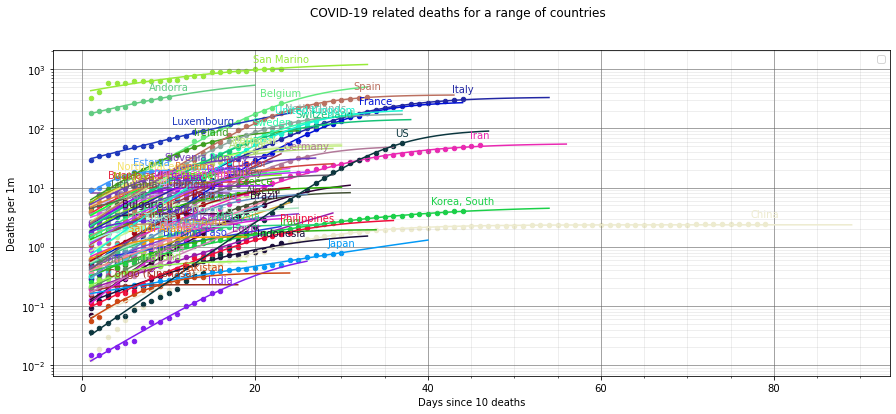

In [76]:

fig, ax = plt.subplots(figsize=(15, 6))
if log_scale:
    ax.set_yscale('log')


countries_fit = []
for country in countries:
    print(f'Processing country: {country}')
    col = np.random.rand(3,)

    #sub_df = ts_df[(ts_df['province_state'] == country) & (ts_df.index.is(country))]
    sub_df = ts_df.loc[country][ts_df.loc[country]['province_state'] == 'total']
    rel_df = sub_df.query('rel_day >= 1')

    if len(rel_df) < MIN_REGRESSION_DATAPOINTS:
        continue

    # rel_df.plot.scatter(x='rel_day', y=label)

    model = LogisticModel
    params = model.make_params(a=1000, b=0.3, c=1000)
    params['a'].min = 0
    params['b'].min = 0
    params['b'].max = 0.5
    params['c'].min = 0
    try:
        result = model.fit(rel_df[label], params, x=rel_df['rel_day'], method=fit_method)
    except (ValueError, TypeError) as e:
        print(f'Skipping {country}. Got fit error: {e}')

    countries_fit.append({
        'zone': country,
        'fit_result': result,
        'fit_a': result.params['a'].value,
        'fit_b': result.params['b'].value,
        'fit_c': result.params['c'].value,
        'cases': rel_df.iloc[-1]['cases'],
        'deaths': rel_df.iloc[-1]['deaths'],
        'recoveries': rel_df.iloc[-1]['recoveries'],
        'cases_per_1M': rel_df.iloc[-1]['cases_per_1M'],
        'deaths_per_1M': rel_df.iloc[-1]['deaths_per_1M'],
        'recoveries_per_1M': rel_df.iloc[-1]['recoveries_per_1M'],
        'deaths_per_recovery': rel_df.iloc[-1]['deaths_per_recovery'],
        'lat': rel_df.iloc[-1]['lat'],
        'long': rel_df.iloc[-1]['long'],
        'day': rel_df.iloc[-1]['day'],
        'rel_day': rel_df.iloc[-1]['rel_day'],
        'x': rel_df['rel_day'],
        'y': rel_df[label],
        'n': n,
        'col': col
    })

    # Labels with result parameters
    axlbl = f'{country:<15} a: {result.params["a"].value:.0f}, b: {result.params["b"].value:.3f}, c: {result.params["c"].value:.5f}'

    rel_df.plot.scatter(x='rel_day', y=label, color=[col], ax=ax, label=axlbl)
   
    # Regression 
    last_rel_day = rel_df['rel_day'].iloc[-1]
    regression_predict_days = np.arange(last_rel_day + 1, last_rel_day + regression_predict_length + 1)

    regression_range = np.append(rel_df['rel_day'].values, regression_predict_days)

    plt.plot(regression_range, result.eval(x=regression_range), color=col)

    # Regression confidence intervals
    for i in range(1, regression_confidence_levels + 1):
        p = result.params
        plt.fill_between(regression_range, model.func(regression_range, p['a'] + i * p['a'].stderr, p['b'] + i * p['b'].stderr, p['c'] + i * p['c'].stderr), model.func(regression_range, p['a'] - i * p['a'].stderr, p['b'] - i * p['b'].stderr, p['c'] - i * p['c'].stderr), color=col, alpha=0.3)

    # Annotate last point
    if annotate_country:
        x = rel_df.iloc[-1]['rel_day']
        y = rel_df.iloc[-1][label]
        ax.annotate(country, (x, y), color=col, textcoords='offset points', xytext=(0, 10), verticalalignment='center', horizontalalignment='center')

ax.set_ylabel(" ".join(label.split("_")).capitalize())
ax.set_xlabel(f"Days since {n} {label.strip('_per_1M')}")
fig.suptitle(f"COVID-19 related {label.strip('_per_1M')} for a range of countries")
plt.grid(b=True, which='major', color='#666666', linestyle='-', alpha=0.75)
plt.grid(b=True, axis='both', which='minor', color="#999999", linestyle='-', alpha=0.2)
plt.minorticks_on()

plt.legend()
if not show_legend:
    plt.legend('')
    plt.show()

# Update zone_df
countries_df = pd.DataFrame(countries_fit)
zone_df = pd.merge(zone_df, countries_df, on='zone', suffixes=('', '_y'))
drop_y(zone_df)


In [79]:
covid_metric = 'deaths_per_1M'
other_metric = 'urbanisation'

subdf = zone_df
subdf = subdf.query('deaths > 25 & continent == "Europe"')

#zone_df.plot.scatter(x='urbanisation', y=metric, ax=ax, ylim=(0, 10000))
#subdf[['urbanisation', metric]].corr()
# px.scatter(x=zone_df['urbanisation'], y=zone_df[metric])
#tls.mpl_to_plotly(fig)
lin_model = ols(f'{covid_metric} ~ {other_metric}', data=subdf).fit()
plot = px.scatter(subdf, x=other_metric, y=covid_metric, hover_name='zone')
plot.show()

corr = subdf.corr()
#print(corr)
print(corr.loc[other_metric][covid_metric])
corr


0.5015982866214262


,population,urbanisation,hospital_beds_per_1K,voice_and_accountability,government_effectiveness,fit_a,fit_b,fit_c,cases,deaths,recoveries,cases_per_1M,deaths_per_1M,recoveries_per_1M,lat,long,day,rel_day,n,deaths_per_recovery
population,1.000000,0.074363,0.421629,-0.227110,-0.125658,0.110869,-0.140520,-0.071638,0.548724,0.439795,0.453371,-0.190706,-0.053301,-0.049711,-0.155250,0.129672,NaN,0.316481,NaN,0.069410
urbanisation,0.074363,1.000000,-0.237062,0.622591,0.717734,-0.007747,-0.677315,0.007560,0.172794,0.169003,0.118603,0.522200,0.501598,0.418235,-0.094163,-0.322649,NaN,0.400502,NaN,0.128911
hospital_beds_per_1K,0.421629,-0.237062,1.000000,-0.420180,-0.348105,0.293752,0.008649,0.205050,-0.030337,-0.189290,0.091984,-0.340631,-0.302645,-0.148993,0.236911,0.354544,NaN,-0.209785,NaN,-0.343885
voice_and_accountability,-0.227110,0.622591,-0.420180,1.000000,0.949507,-0.058585,-0.521608,0.055009,0.214164,0.175133,0.192675,0.382393,0.278316,0.383833,-0.066893,-0.509644,NaN,0.481935,NaN,0.200737
government_effectiveness,-0.125658,0.717734,-0.348105,0.949507,1.000000,-0.075471,-0.498330,0.020756,0.276228,0.217037,0.248123,0.450474,0.407889,0.450019,-0.101679,-0.532608,NaN,0.499540,NaN,0.279300
fit_a,0.110869,-0.007747,0.293752,-0.058585,-0.075471,1.000000,-0.193789,0.963446,-0.130433,-0.116972,-0.108808,-0.180123,-0.139963,-0.172232,0.088022,0.234027,NaN,-0.194165,NaN,-0.091622
fit_b,-0.140520,-0.677315,0.008649,-0.521608,-0.498330,-0.193789,1.000000,-0.180437,-0.023634,-0.029475,-0.019053,-0.452130,-0.352982,-0.369663,-0.128520,-0.025567,NaN,-0.221263,NaN,0.084350
fit_c,-0.071638,0.007560,0.205050,0.055009,0.020756,0.963446,-0.180437,1.000000,-0.127038,-0.106608,-0.100447,-0.159017,-0.125555,-0.153631,0.074155,0.119465,NaN,-0.164687,NaN,-0.080752
cases,0.548724,0.172794,-0.030337,0.214164,0.276228,-0.130433,-0.023634,-0.127038,1.000000,0.920501,0.901158,0.085802,0.239784,0.338684,-0.235024,-0.383729,NaN,0.813686,NaN,0.060781
deaths,0.439795,0.169003,-0.189290,0.175133,0.217037,-0.116972,-0.029475,-0.106608,0.920501,1.000000,0.703486,0.104764,0.306464,0.269918,-0.310645,-0.418494,NaN,0.819350,NaN,0.125208


In [71]:
wbdata.search_indicators('hospital')

IN.HLTH.DISTHOSPTL.NUM        	Number of District Hospitals
IN.HLTH.GOVHOSPTL.BEDS.NUM    	Government Hospitals Number of beds
IN.HLTH.GOVHOSPTL.BEDS.PER100K	Government Hospitals Number of beds Per 100,000 Population
IN.HLTH.GOVHOSPTL.NUM         	Government Hospitals (Number)
IN.HLTH.GOVHOSPTL.PER100K     	Government Hospitals (Number) Per 100,000 Population
SH.HOSP.TOTL                  	Number of hospitals
SH.MED.BEDS.ZS                	Hospital beds (per 1,000 people)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
=================================================================
Model:              OLS              Adj. R-squared:     0.225   
Dependent Variable: deaths_per_1M    AIC:                396.9826
Date:               2020-04-11 23:24 BIC:                399.7849
No. Observations:   30               Log-Likelihood:     -196.49 
Df Model:           1                F-statistic:        9.413   
Df Residuals:       28               Prob (F-statistic): 0.00474 
R-squared:          0.252            Scale:              30654.  
-----------------------------------------------------------------
               Coef.   Std.Err.    t    P>|t|    [0.025   0.975] 
-----------------------------------------------------------------
Intercept    -381.5580 164.3845 -2.3211 0.0278 -718.2843 -44.8317
urbanisation    6.7382   2.1962  3.0681 0.0047    2.2395  11.2370
-----------------------------------------------------------------
Omnibus:             39.197       Durbin-Watson:          2.177  
Prob(Omnibus):       0.000        Jarque-Bera (JB):       138.037
Skew:                2.655        Prob(JB):               0.000  
Kurtosis:            12.068       Condition No.:          385    
=================================================================

"""

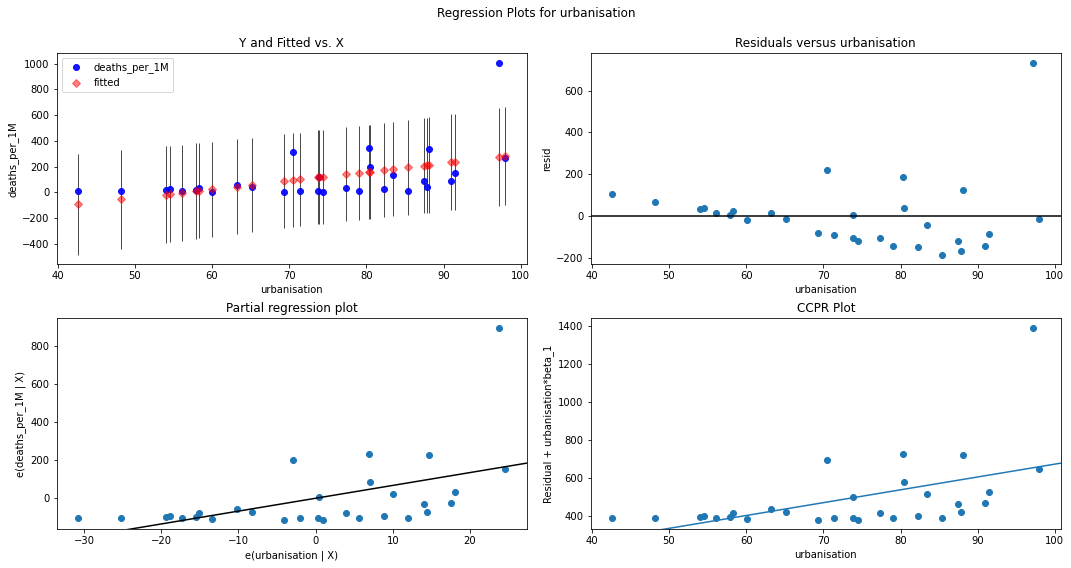

In [72]:
fig = plt.figure(figsize=(15, 8))
fig = sm.graphics.plot_regress_exog(lin_model, other_metric, fig=fig)
lin_model.summary2()

In [73]:

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

world.rename(columns={'name': 'zone'}, inplace=True)

a = world.merge(new_df, on='zone', how='outer')

a.query('continent == "Europe"').query('zone != "Russia"').plot(column='deaths_per_1M', legend=True, cmap='summer', missing_kwds={
    "color": 'lightgrey'
})

NameError: name 'new_df' is not defined

# Country Bayersian fit


import lmfit
country = 'Denmark'
province_state = 'total'
label = 'cases'
regression_predict_length = 50
log_scale = True
emcee_factor = 1.0/1

c_df = ts_df.loc[country].query(f'province_state == "{province_state}"')

rel_df = c_df.query('rel_day >= 1')
# rel_df.plot(x='rel_day', y=label)

model = LogisticModel
params = model.make_params(a=1000, b=0.3, c=1000)
params['a'].min = 0
params['b'].min = 0
params['b'].max = 0.5
params['c'].min = 0
result_leastsq = model.fit(rel_df[label], params, x=rel_df['rel_day'], method='leastsq', nan_policy='omit')
result_nelder = model.fit(rel_df[label], params, x=rel_df['rel_day'], method='Nelder', nan_policy='omit')

emcee_kws = {
    'steps': int(round(1000 * emcee_factor)),
    'burn': int(round(300 * emcee_factor)),
#    'thin': 20,
    'is_weighted': False,
    'progress': True
}

emcee_params = result_nelder.params.copy()
emcee_params.add('__lnsigma', value=np.log(0.1), min=np.log(0.001), max=np.log(2.0))

result_emcee = model.fit(rel_df[label], emcee_params, x=rel_df['rel_day'], method='emcee', nan_policy='omit', fit_kws=emcee_kws)

last_rel_day = rel_df['rel_day'].iloc[-1]
regression_predict_days = np.arange(last_rel_day + 1, last_rel_day + regression_predict_length + 1)

regression_range = np.append(rel_df['rel_day'].values, regression_predict_days)

# result.plot()

fig, ax = plt.subplots(figsize=(20, 6))
if log_scale:
    ax.set_yscale('log')

p = result_leastsq.params

plt.scatter(rel_df['rel_day'], rel_df[label])
plt.plot(regression_range, model.func(regression_range, p['a'], p['b'], p['c']))
# Plot confidence intervals
for i in range(1, 2):
    dely = result_leastsq.eval_uncertainty(sigma=i, x=regression_range)
    plt.fill_between(regression_range, model.func(regression_range, p['a'], p['b'], p['c']) + dely, model.func(regression_range, p['a'], p['b'], p['c']) - dely, color='#ABABAB', alpha=0.3, label=f'{i} $\sigma$ confidence interval')

plt.legend()
#e_result = result.emcee()

In [74]:
fig, ax = plt.subplots(figsize=(20, 6))
#ax.set_yscale('log')
ax.set_ylabel(label)
sigma_n = 1

# Emcee fit
p = result_emcee.params
color = (1.0, 0.0, 0.0)
#plt.fill_between(regression_range, model.func(regression_range, p['a'], p['b'] + p['b'].stderr, p['c']), model.func(regression_range, p['a'], p['b'] - p['b'].stderr, p['c']), color=color, alpha=0.2)
#plt.plot(regression_range, model.func(regression_range, p['a'], p['b'], p['c']), color=color, label='emcee fit')

# Least squares fit
p = result_leastsq.params
color = (0.0, 1.0, 0.0)
#plt.fill_between(regression_range, model.func(regression_range, p['a'] + p['a'].stderr, p['b'] + p['b'].stderr, p['c'] + p['c'].stderr), model.func(regression_range, p['a'] - p['a'].stderr, p['b'] - p['b'].stderr, p['c'] - p['c'].stderr), color=color, alpha=0.2)
#plt.plot(regression_range, model.func(regression_range, p['a'], p['b'], p['c']), color=color, label='leastsq fit')
plt.fill_between(regression_range, model.func(regression_range, p['a'] + sigma_n * p['a'].stderr, p['b'] + sigma_n * p['b'].stderr, p['c'] + sigma_n * p['c'].stderr), model.func(regression_range, p['a'] - sigma_n * p['a'].stderr, p['b'] - sigma_n * p['b'].stderr, p['c'] - sigma_n * p['c'].stderr), color=color, alpha=0.2)

# Nelder fit
p = result_nelder.params
color = (0.0, 0.0, 1.0)
#plt.fill_between(regression_range, model.func(regression_range, p['a'], p['b'] + p['b'].stderr, p['c']), model.func(regression_range, p['a'], p['b'] - p['b'].stderr, p['c']), alpha=0.2)
#plt.plot(regression_range, model.func(regression_range, p['a'], p['b'], p['c']), color=color, label='Nelder fit')

# Test
p = result_emcee.params
color = (0.0, 0.0, 0.0)
#plt.fill_between(regression_range, model.func(regression_range, p['a'] + sigma_n * p['a'].stderr, p['b'] + sigma_n * p['b'].stderr, p['c'] + sigma_n * p['c'].stderr), model.func(regression_range, p['a'] - sigma_n * p['a'].stderr, p['b'] - sigma_n * p['b'].stderr, p['c'] - sigma_n * p['c'].stderr), color=color, alpha=0.2)
#plt.plot(regression_range, model.func(regression_range, p['a'], p['b'], p['c']), color=color, label='test fit')


# Actual data
plt.scatter(rel_df['rel_day'], rel_df[label], label=f'{country}')
plt.legend()

NameError: name 'result_emcee' is not defined